# The One Goal for Today

Understand how to fit a naive Bayes model using text data.


In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

# Naive Bayes for Spam

Text data, *without preprocessing*, is qualitative data. Let's use Naive Bayes to classify some text data! 

I'm going to be using the SMS dataset from [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

## I. Load and Look at our data

Let's load and __look at our data__. Is our independent variable at the *start* or the *end*?

In [2]:
data = np.array(np.genfromtxt('data/SMSSpamCollection', delimiter='\t', encoding='utf-8', dtype=str))  
print(data.shape)
print(data[2], "\n", data[4], "\n", data[9], "\n", data[10], "\n", data[11], "\n", data[12], "\n", data[14], "\n", data[20], "\n", data[29], "\n", data[32])

(5574, 2)
['spam'
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"] 
 ['ham' "Nah I don't think he goes to usf, he lives around here though"] 
 ['spam'
 'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030'] 
 ['ham'
 "I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."] 
 ['spam'
 'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info'] 
 ['spam'
 'URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18'] 
 ['ham' 'I HAVE A DATE ON SUNDAY WITH WILL!!'] 
 ['ham' 'Is that seriously how you spell his name?'] 
 ['ham' 'Ahhh. Work. I vaguely r

How many labels do we have?

In [3]:
print(np.unique(data[:, 0], return_counts=True))

(array(['ham', 'spam'], dtype='<U910'), array([4827,  747]))


## II. Split the data

Let's split it into train and test and make sure we have some of each label in each subset

In [4]:
train, test = np.split(data, [int(.8 * len(data))])
print(train.shape, test.shape)
print(np.unique(train[:, 0], return_counts=True))
print(np.unique(test[:, 0], return_counts=True))

(4459, 2) (1115, 2)
(array(['ham', 'spam'], dtype='<U910'), array([3857,  602]))
(array(['ham', 'spam'], dtype='<U910'), array([970, 145]))


So far, so good!

## III. Preprocess the data

*But*, how do I deal with the SMS texts themselves? Well, a SMS is composed of word-type things (let's call them "tokens") and if I *completely ignore* the sequence information then I could say each SMS is composed of a *bag* of tokens. 

NOTE that to do this hurts me as a computational linguist. Of *course* word order matters! In particular, in this context it means that the token occurrences are not *independent* of each other. But we are going to pretend they are, thus lacerating the sensibilities of both linguists and statisticians in search of a computationally efficient approximation.

__Our independent variables will be what, now?__

### Let's define a function to get the bag of tokens from the text of a SMS

In [5]:
# We will split the text on any character(s) that are not letters or numbers,
# and then keep anything that is not whitespace
def tokenize(text):
    # split on whitespace - \s+ - and strip off any whitespace
    return [token.strip() for token in re.split(r'(\s+)', text) if not re.match(r'^\s*$', token)]

In [6]:
# Try it on one SMS
tokenize(train[0][1])

['Go',
 'until',
 'jurong',
 'point,',
 'crazy..',
 'Available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet...',
 'Cine',
 'there',
 'got',
 'amore',
 'wat...']

### Let's get the unique tokens

We do this on **train only**.

In [7]:
# all the tokens
tokens = []
for i in range(len(train)):
    # add the tokens from this training data point to the list of all the tokens
    tokens.extend(tokenize(train[i][1]))
# get the unique tokens
unique_tokens, token_counts = np.unique(tokens, return_counts=True)
# how many do we have?
print(len(unique_tokens))
# what are some of them?
print(list(unique_tokens)[0:9])

13409
['!', '!!', '!!!', '!!!!', "!!''.", '!1', '"', '".', '"3000']


That's entirely too many tokens! Let's keep just from the $a$ to the $b$ most frequent ones.

In [8]:
a = 75
b = 2000
# all the tokens
tokens = []
for i in range(len(train)):
    # add the tokens from this training data point to the list of all the tokens
    tokens.extend(tokenize(train[i][1]))
# get the unique tokens
unique_tokens, token_counts = np.unique(tokens, return_counts=True)
# sort them by the counts; reverse the sort so it goes from largest to smallest; keep only the ones between a and b
top_unique_tokens = unique_tokens[np.argsort(token_counts)[::-1]][a:b]
print(len(top_unique_tokens))
print(top_unique_tokens[0:9])

1925
['But' 'still' 'text' 'one' 'our' 'been' 'its' 'If' 'love']


### Let's collect token counts across all the 'ham' SMSs, and separately across all the 'spam' SMSs

In [9]:
# subset_of_data means all the data points in a class / with the same value for the dependent variable
# token_vocab is the set of most frequent unique tokens we care about
def preprocess_category(subset_of_data, token_vocab):
    # the tokens in the data points in this class
    tokens = []
    for i in range(len(subset_of_data)):
        # add the tokens from this data point to tokens
        tokens.extend(tokenize(subset_of_data[i][1]))
    # get the unique tokens
    unique_tokens, token_counts = np.unique(tokens, return_counts=True)
    # we only want to keep those in token_vocab
    res = dict.fromkeys(token_vocab, 0)
    # add the count for each token that is in this class and that is a token we care about to res
    for token, count in zip(unique_tokens, token_counts):
        if token in res:
            res[token] += count
    return res

In [10]:
token_counts = {}
# get token counts for ham
token_counts['ham'] = preprocess_category(train[np.where(train[:, 0] == 'ham')], top_unique_tokens)
# get token counts for spam
token_counts['spam'] = preprocess_category(train[np.where(train[:, 0] == 'spam')], top_unique_tokens)
# We keep this around for indexing into the likelihoods
sorted_tokens = sorted(top_unique_tokens)
print(len(sorted_tokens))

1925


Pay attention to the sleight of hand here:
* Our labels are 'ham' and 'spam'.
* Our features are individual token frequencies calculated across all of 'ham' and all of 'spam'. We *assume independence in the features*. That's the naive in Naive Bayes.

## Fit

So now let's fit a Naive Bayes model for spam detection

To fit, we need to calculate:
* priors - $P(ham)$ and $P(spam)$
* likelihoods - for any token $x$, $P(x|ham)$ and $P(x|spam)$

### Priors

Calculating priors will be easy. 

In [11]:
priors = {'ham': len(train[np.where(train[:, 0] == 'ham')]) / len(train), 'spam': len(train[np.where(train[:, 0] == 'spam')]) / len(train)}
print(priors)

{'ham': 0.8649921507064364, 'spam': 0.13500784929356358}


### Likelihoods

Calculating likelihoods will be tricky, because:.
* Sometimes the likelihoods will be 0, as a token will occur *no* times in one of 'ham' or 'spam'.
* A lot of the likelihoods will be veerrrry small, as most of the tokens occur only once.

To deal with these, we:
* 0s - use *Laplace smoothing*.
* veerrrry small - move from regular count space to log space (see plot).
  * in 'regular count space' $P(I, like, candy) | ham) = P(I|ham)*P(like|ham)*P(candy|ham)$.
  * in 'log space' $P(I, like, candy) | ham) = log(P(I|ham)) + log(P(like|ham)) + log(P(candy|ham))$, because the logarithm of a product is the sum of the logarithms.

Let's visualize the difference between count space and log space.


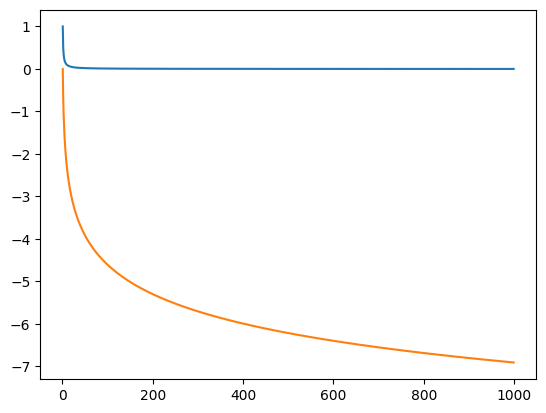

In [12]:
res = np.array([[i, 1/i, np.log(1/i)] for i in range(1, 1000)])
plt.plot(res[:, 0], res[:, 1])
plt.plot(res[:, 0], res[:, 2])
plt.show()

Let's calculate the log likelihoods using Laplace smoothing of 1.

In [13]:
def calculate_likelihoods(data, sorted_tokens, token_counts):
    likelihoods = {}
    # assume we have all the possible values for the dependent variable in this data subset.
    cats = np.unique(data[:, 0])
    # for each possible outcome
    for cat in cats:
        likelihoods[cat] = {}
        # for each possible value of the independent variable
        for token in sorted_tokens:
            # add 1 in the numerator for Laplace smoothing; add the number of possible values of the independent variable to the denominator for Laplace smoothing
            # take the log of the likelihood
            likelihoods[cat][token] = np.log((token_counts[cat][token] + 1) / 
                                             (len(np.where([data[:, 0] == cat])) + len(sorted_tokens)))
    return likelihoods

In [14]:
likelihoods = calculate_likelihoods(train, sorted_tokens, token_counts)
# sanity check!
print(len(likelihoods))
print(len(likelihoods['ham']))
print(len(likelihoods['spam']))

2
1925
1925


## Predict

Let's use the Naive Bayes model we fit to predict the class for each item in our test data.

We will have to tokenize each SMS, of course.

In [16]:
def p_text_given_category(text, cat, likelihoods):
    tokens = tokenize(text)
    sum = 0
    for token in tokens:
        # if the token is not in our vocab from train, it just gets dropped
        try:
            likelihood = likelihoods[cat][token]
        except:
            likelihood = 0
        # we add instead of multiply, because we are in log space
        sum += likelihood
    return sum
        
def predict(data, priors, likelihoods):
    labels = []
    cats = np.unique(data[:, 0])
    for i in range(len(data)):    
        res = []
        for cat in cats:
            # we add instead of multiply, because we are in log space
            res.append(np.log(priors[cat]) + p_text_given_category(data[i][1], cat, likelihoods))
        # take the argmax, and also its probability - take the exponent to get us out of log space
        labels.append((cats[np.argmax(res)], np.exp(res[np.argmax(res)])))
    return labels

In [17]:
labels = predict(test, priors, likelihoods)
print(labels)

[('ham', 1.3083772514806825e-07), ('spam', 2.3630609743695414e-16), ('ham', 8.249739126775618e-32), ('ham', 4.033436203760512e-43), ('ham', 2.1185877959239838e-10), ('ham', 7.242963403975517e-26), ('ham', 0.004937682230291021), ('spam', 3.4903326724300753e-06), ('ham', 0.0012939956026450268), ('ham', 1.2676967122416785e-27), ('ham', 7.267806085062975e-05), ('ham', 2.964394139278562e-34), ('ham', 2.1676899684480647e-11), ('ham', 0.8649921507064364), ('ham', 4.7424974210780004e-11), ('ham', 8.038752688792993e-08), ('spam', 1.3815900161702397e-05), ('ham', 5.191905510027772e-08), ('ham', 0.0011293052532174784), ('ham', 1.8495739942204217e-09), ('ham', 0.0003960022546348414), ('ham', 0.8649921507064364), ('ham', 3.445951320571062e-08), ('ham', 0.002693281216522376), ('ham', 4.376346509076042e-08), ('ham', 1.1860283169353899e-21), ('ham', 3.074841035988183e-05), ('ham', 9.084757606328726e-05), ('ham', 2.110384126931552e-06), ('ham', 1.6127858599671407e-15), ('ham', 2.445896278626966e-05), (

## Score

Let's get accuracy and the confusion matrix.

In [18]:
# These come directly from day 24

def accuracy(y, yhat):
    assert len(y) == len(yhat)
    diffs = y == yhat
    vals, counts = np.unique(diffs, return_counts=True)
    return counts[np.where(vals == True)] / (np.sum(counts))
    
def confusion_matrix(y, yhat):
    "Thanks to https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python"
    allLabels = sorted(list(np.union1d(y, yhat)))
    print(allLabels)
    assert len(y) == len(yhat)
    result = np.zeros((len(allLabels), len(allLabels)))
    for i in range(len(y)):
        result[allLabels.index(y[i])][allLabels.index(yhat[i])] += 1
    return result

In [20]:
accuracy([x[0] for x in labels], test[:, 0])

array([0.96053812])

In [21]:
confusion_matrix([x[0] for x in labels], test[:, 0])

['ham', 'spam']


array([[965.,  39.],
       [  5., 106.]])

Note that accuracy isn't super helpful here, since there are so many 'ham' emails. 

Question: *What would the accuracy be if the model just labeled __everything__ as 'ham'?*

## TPR, FPR, Precision, Recall, F

Let's make a different version of the confusion matrix focusing on just the 'spam' class, which is the class we really want to do well on:

| | Predict not in 'spam' | Predict in 'spam' | Rates |
| -- | --- | --- | -- |
| Actual not in 'spam' | TN | FP | FPR = FP/(FP+TN) |
| Actual in 'spam' | FN | TP | TPR = TP/(TP+FN) |


| | Predict not in 'spam' | Predict in 'spam' | Rates |
| -- | --- | --- | -- |
| Actual not in 'spam' | 965 | 39 | .04 |
| Actual in 'spam' | 5 | 106 | .95 |

With a table like this, we can also calculate:
* Precision (how many of those we guessed were 'spam' were actually 'spam'?): TP / (TP + FP), .73
* Recall (how many actual 'spam' did we guess were 'spam'?): TP / (TP + FN), .95

Then, to get an assessment of recall and precision together, we can calculate F1: (2\*Precision\*Recall)/(Precision+Recall), .85

## Are we happy?

We could potentially do better:
* We could add information from *outside the text*. Modern spam filters use features like whether the sender's email address is the same as the reply-to email address, whether the IP address the email comes from matches that of the domain of the sender's email address, whether this same email is being sent to a lot of people at the same time, whether this sender has ever emailed this recipient before (and how often), and all kinds of behavioral features.
* We have a *class imbalance*: there are a lot more 'ham' emails than there are 'spam' emails. We can deal with this by *changing the decision threshold*, *downsampling* the 'ham' emails, *upsampling* (repeating) the 'spam' emails, or [other techniques](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/?msclkid=33d6b961b9df11ec98e519046a973ddf).

In [22]:
my_texts = np.array([['ham', 'Thank you!'], ['spam', 'hey how are things'], ['ham', 'How is second puppy training going?'], ['ham', 'Your Clear Enrollment verification code is xxxx']])
pred = predict(my_texts, priors, likelihoods)
print(pred)

[('ham', 5.2412063113434996e-05), ('ham', 0.0006354671474375571), ('ham', 1.8635400218110196e-05), ('spam', 1.7015371778096626e-05)]


# For the project

For the project, you will need to load all the files in the ham folder, and all the files in the spam folder. You may use the python **glob** functionality for this. 
* For each directory in the enron directory (ham, spam):
  * For each .txt file in the directory:
    * Read the text in the file
    * Tokenize the text
    * For each token:
      * If it's not in the dictionary of token counts, add it there
      * Increment the count

For the project, you will keep only the 200 most frequent tokens.

Then, you will encode each headline uas a 200 dimensional vector (one column per token), and the labels as 0 or 1 for each headline (0 for spam, 1 for ham).

Then, you will want to split the data into train and test, and save the training and test data into separate files.

The whole process will look very similar to what we have just done.

Resources:
* https://towardsdatascience.com/roc-curve-and-auc-from-scratch-in-numpy-visualized-2612bb9459ab
* https://towardsdatascience.com/roc-and-auc-how-to-evaluate-machine-learning-models-in-no-time-fb2304c83a7f